# RecSys Project

Автор: Яковлев Дмитрий
Метрика: AP@5 - средняя точность рекомендаций

# Задание:

 Предсказать какие следующие 5 товаров купят клиенты магазина.

 НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекомендательные системы в проекте. Данные следующие:
 
   • hh_demographic.csv - фичи пользователей. 
    
   • product.csv - фичи товарова. 
    
   • retail_train.csv - взаимодействие пользователей с товарами. 
    
   • test_users.csv - список пользователей для которого необходимо предоставить предсказания. 
    
    


В датасете юзеры, которые в подавляющем большинстве покупают одно и то же, и перебить baseline, который рекомендует самые популярные товары не так то просто. После добавления киллер-фичи у конечного предсказания дикий рост метрик на валидации, которое почти не зависит от метрики модели на тренировочном датасете.. И дальнейшее увеличение метрики модели на трейне приводит к уменьшению метрики на валидации. В тот момент не знал продвинутых методов настройки валидации, поэтому не смог добиться дальнейшего улучшения качества модели.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier
import lightgbm

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k

In [2]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [3]:
def ap_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    flags = np.isin(recommended_list, bought_list)
    
    if sum(flags) == 0:
        return 0
    
    sum_ = 0
    for i in range(1, k+1):
        
        if flags[i - 1] == True:
            p_k = precision_at_k(recommended_list, bought_list, k=i)
     #             print(p_k)
            
            sum_ += p_k
            
    result = sum_ / min(len(recommended_list), k)
    
    return result

In [4]:
def get_recommendations(data, N):

    overall = data.groupby('item_id')['quantity'].count().reset_index()
    overall.sort_values('quantity', ascending=False, inplace=True)
    overall = overall[overall['item_id'] != 999999]
    overall = overall.item_id.tolist()
    
    return overall[:N]

In [5]:
import seaborn as sns
from sklearn.impute import KNNImputer
import plotly.express as px
import re

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2 # подсчитываем память потребляемую изначальным датасетом
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns: # проходимся по всем колонкам
        col_type = df[col].dtype  # узнаем тип колонки
        
        if col_type != object:
            c_min = df[col].min() # смотрим минимальное значение признака
            c_max = df[col].max() # смотрим максимальное значение признака
            if str(col_type)[:3] == 'int':  # if int
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: # сравниваем с int8
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: # сравниваем с int16 и.т.д.
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: # если был тип object, то меняем его тип на пандасовский тип 'category', на нем разные агрегации данных работают в разы быстрее
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # считаем сколько теперь у нас занято памяти
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))  # и выводим статистику
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
data = pd.read_csv('data/retail_train.csv')

In [8]:
data = reduce_mem_usage(data)

Memory usage of dataframe is 219.43 MB
Memory usage after optimization is: 98.29 MB
Decreased by 55.2%


In [9]:
item_features = pd.read_csv('data/product.csv')
user_features = pd.read_csv('data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 5 недель -- | -- 3 недель -- 

val_lvl_1_size_weeks = 5
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [10]:
item_features = reduce_mem_usage(item_features)

Memory usage of dataframe is 4.93 MB
Memory usage after optimization is: 1.49 MB
Decreased by 69.9%


In [11]:
user_features = reduce_mem_usage(user_features)

Memory usage of dataframe is 0.05 MB
Memory usage after optimization is: 0.01 MB
Decreased by 82.6%


In [12]:
# Статистики будем собирать на data_train
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]

# Оставляю юзеров более чем 84 итемов (увеличил скор)

In [13]:
data_train.shape

(2278490, 12)

In [14]:
users_over_8_items = data_train.groupby('user_id')['item_id'].nunique().reset_index()\
            .rename(columns = {'item_id': 'nunique_item_id'})
users_over_8_items = users_over_8_items[users_over_8_items['nunique_item_id'] > 84]
users_over_8_items = users_over_8_items['user_id'].to_list()

In [15]:
data_train.shape

(2278490, 12)

In [16]:
data_train_lvl_1 = data_train_lvl_1.query('user_id in @users_over_8_items')
data_train_lvl_2 = data_train_lvl_2.query('user_id in @users_over_8_items')
data_train = data_train.query('user_id in @users_over_8_items')

In [17]:
data = data.query('user_id in @users_over_8_items')

# EDA

# data_train

In [18]:
df_numerical2 = data_train.select_dtypes(include = [np.number])
df_categorical2 = data_train.select_dtypes(exclude = [np.number])

In [19]:
for i in df_numerical2.columns:
    print(i, data_train[i][data_train[i]==0].count())

user_id 0
basket_id 0
day 0
item_id 0
quantity 12598
sales_value 16482
store_id 0
retail_disc 1126114
trans_time 413
week_no 0
coupon_disc 2233556
coupon_match_disc 2250196


# quantity

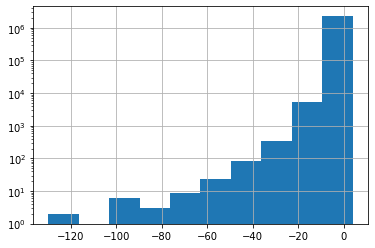

In [20]:
data_train.loc[data_train['retail_disc'] > -200, 'retail_disc'].hist()

plt.yscale('log')

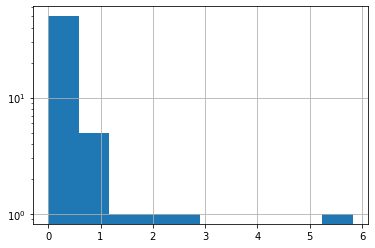

In [21]:
data_train.loc[(data_train['quantity']==0) & (data_train['sales_value']!=0), 'sales_value'].hist()
plt.yscale('log')

У sales_value меньше чем 0,5 значений на порядок больше. А больше 1 ничтожное количество.

In [22]:
# Уменьшил скор на 1%
#data_train = data_train.loc[~((data_train['quantity']==0) & (data_train['sales_value']==0))]

# retail_disc

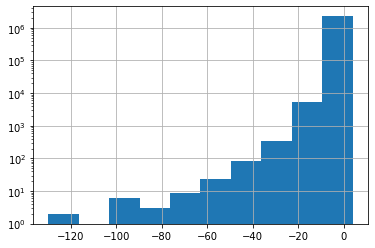

In [23]:
data_train.loc[data_train['retail_disc'] > -200, 'retail_disc'].hist()

plt.yscale('log')

In [24]:
data_train[data_train['retail_disc'] > 0].head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
968972,1306,31624096856,310,990941,0,0.01,340,1.000000e-02,2253,45,0.0,0.0
1001608,1306,31735306143,318,7409789,0,0.00,381,2.220446e-16,1232,46,0.0,0.0
1023085,1321,31803641901,323,1051069,0,0.00,364,5.551115e-17,1931,47,0.0,0.0
1023086,1321,31803641901,323,1055863,0,0.00,364,5.551115e-17,1931,47,0.0,0.0
1067337,37,31944616637,334,8090539,0,0.00,381,2.220446e-16,1434,48,0.0,0.0


Хоть что с этими строками не делай, метрика не поменялась. Удалил.

In [25]:
#data_train = data_train.loc[~(data_train['retail_disc'] > 0)]

# coupon_disc

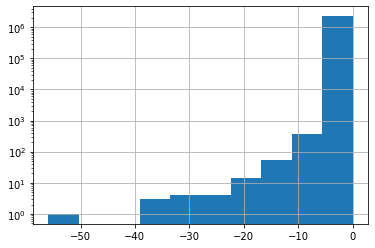

In [26]:
data_train.loc[data_train['coupon_disc'] > -100, 'coupon_disc'].hist()

plt.yscale('log')

выбросы по 1 шт.

# coupon_match_disc

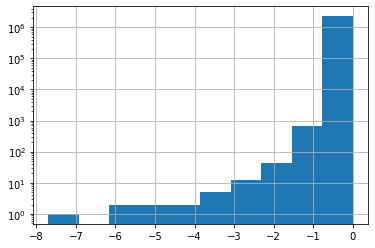

In [27]:
data_train.loc[data_train['coupon_match_disc'] > -20, 'coupon_match_disc'].hist()

plt.yscale('log')

# week_no

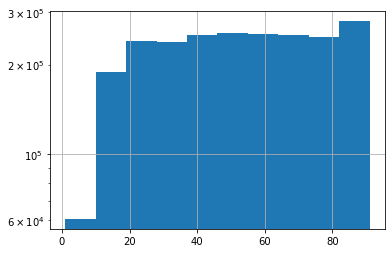

In [28]:
data_train.loc[data_train['week_no'] < 1000, 'week_no'].hist()

plt.yscale('log')

In [29]:
data_train['day'].max()

635

In [30]:
data_train['week_no'].max()

91

In [31]:
91*7

637

# day

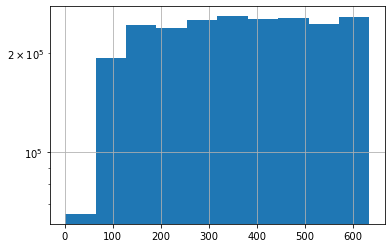

In [32]:
data_train.loc[data_train['day'] < 10000, 'day'].hist()

plt.yscale('log')

<AxesSubplot:>

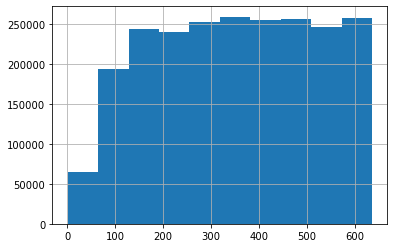

In [33]:
data_train.loc[data_train['day'] < 10000, 'day'].hist()

# sales_value

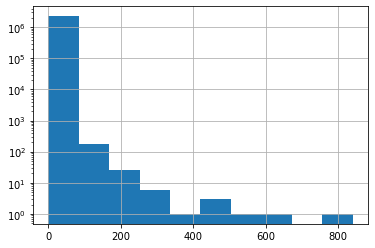

In [34]:
data_train.loc[data_train['sales_value'] < 10000, 'sales_value'].hist()

plt.yscale('log')

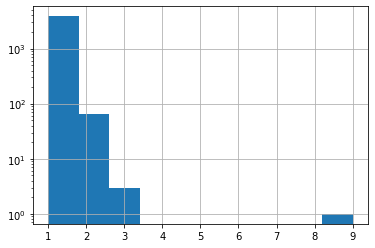

In [35]:
data_train.loc[(data_train['sales_value'] == 0) & (data_train['quantity'] != 0), 'quantity'].hist()
plt.yscale('log')

In [36]:
data_train[(data_train['sales_value'] == 0) & (data_train['quantity'] != 0)]

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
766,2110,27009082349,3,837963,1,0.0,375,0.00,1547,1,0.0,0.0
996,568,27021090189,4,951412,1,0.0,446,-1.48,35,1,0.0,0.0
1095,2110,27021248054,4,850115,1,0.0,375,-3.29,1705,1,0.0,0.0
1113,2110,27021248054,4,976872,1,0.0,375,-2.49,1705,1,0.0,0.0
1161,474,27021262361,4,940108,1,0.0,352,-1.19,2204,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2276178,825,41260374710,635,16769972,1,0.0,375,-4.95,1718,91,0.0,0.0
2276386,1142,41260421242,635,991268,1,0.0,335,-2.59,1301,91,0.0,0.0
2276968,2331,41260512294,635,16769972,1,0.0,341,-4.95,1849,91,0.0,0.0
2276995,2119,41260512581,635,10121920,1,0.0,341,-3.99,2115,91,0.0,0.0


Если обработать data_train префильтрацией, эти строки отсутствуют. Цена итема зависит от времени, поэтому для расчета sales_value для каждого итема нужно добавить а потом удалить фичу в датасет. После удаления этих строк precision увеличился на 0,26%

In [37]:
#data_train = data_train.loc[~(data_train['sales_value'] == 0) & (data_train['quantity'] != 0)]

# data_train_lvl_1

Фича price неправдивая и не нужная, дропаю

In [38]:
df_numerical3 = data_train_lvl_1.select_dtypes(include = [np.number])
df_categorical3 = data_train_lvl_1.select_dtypes(exclude = [np.number])

In [39]:
for i in df_numerical3.columns:
    print(i, data_train_lvl_1[i][data_train_lvl_1[i]==0].count())

user_id 0
basket_id 0
day 0
item_id 0
quantity 11608
sales_value 15274
store_id 0
retail_disc 1059678
trans_time 367
week_no 0
coupon_disc 2095373
coupon_match_disc 2110753


# data_train_lvl_2

In [40]:
df_numerical4 = data_train_lvl_2.select_dtypes(include = [np.number])
df_categorical4 = data_train_lvl_2.select_dtypes(exclude = [np.number])

In [41]:
for i in df_numerical4.columns:
    print(i, data_train_lvl_2[i][data_train_lvl_2[i]==0].count())

user_id 0
basket_id 0
day 0
item_id 0
quantity 990
sales_value 1208
store_id 0
retail_disc 66436
trans_time 46
week_no 0
coupon_disc 138183
coupon_match_disc 139443


В этом датасете фичи в обучении мало участвуют, т.к. всю важность на себя перетянула синтетическая фича. Поэтому проверяю как на скор будет влиять удаление строк датасета. Первым делом тупо удалю все строки где quantity = 0.

In [42]:
# скор упал на 1%
#data_train_lvl_2 = data_train_lvl_2.loc[~((data_train_lvl_2['quantity']==0))]

# retail_disc

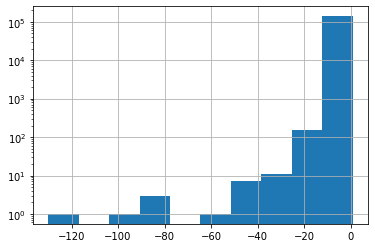

In [43]:
data_train_lvl_2.loc[data_train_lvl_2['retail_disc'] > -200, 'retail_disc'].hist()

plt.yscale('log')

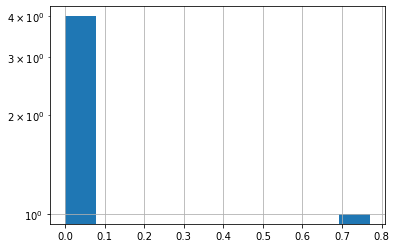

In [44]:
data_train_lvl_2.loc[(data_train_lvl_2['quantity']==0) & (data_train_lvl_2['sales_value']!=0), 'sales_value'].hist()
plt.yscale('log')

In [45]:
data_train_lvl_2[data_train_lvl_2['quantity'] == 0]

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2137160,2395,40715127657,601,919766,0,0.0,31782,0.0,2051,87,0.0,0.0
2137293,1633,40715142595,601,1042697,0,0.0,32004,0.0,2042,87,0.0,0.0
2137720,1160,40715227791,601,939965,0,0.0,316,0.0,1842,87,0.0,0.0
2137953,2130,40715244117,601,5978648,0,0.0,429,0.0,2258,87,0.0,0.0
2138039,1394,40715266574,601,901912,0,0.0,396,0.0,1721,87,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2277175,911,41260536979,635,995785,0,0.0,421,0.0,1359,91,0.0,0.0
2277218,297,41260537249,635,15966375,0,0.0,421,0.0,1437,91,0.0,0.0
2277413,1907,41260571699,635,1103292,0,0.0,369,0.0,1824,91,0.0,0.0
2277742,22,41260616899,635,5978656,0,0.0,365,0.0,1341,91,-1.5,0.0


In [46]:
# уменьшил скор на 1%
#data_train_lvl_2 = data_train_lvl_2.loc[~((data_train_lvl_2['quantity']==0)\
                #& (data_train_lvl_2['sales_value']==0))]

# sales_value

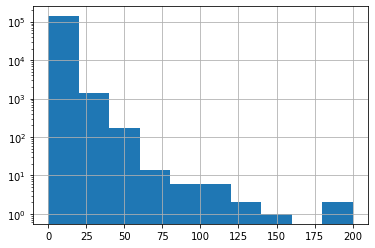

In [47]:
data_train_lvl_2.loc[data_train_lvl_2['sales_value'] < 10000, 'sales_value'].hist()

plt.yscale('log')

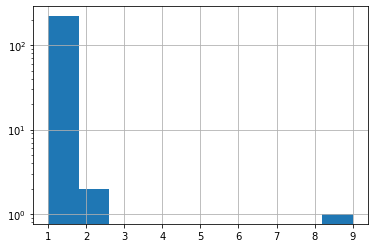

In [48]:
data_train_lvl_2.loc[(data_train_lvl_2['sales_value'] == 0) & (data_train_lvl_2['quantity'] != 0), 'quantity'].hist()
plt.yscale('log')

In [49]:
data_train_lvl_2[(data_train_lvl_2['sales_value'] == 0) & (data_train_lvl_2['quantity'] != 0)]

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2136939,2133,40715096165,601,1014948,1,0.0,362,-3.99,1641,87,0.0,0.0
2138592,973,40715353936,601,995387,1,0.0,382,-3.39,2030,87,0.0,0.0
2140230,2280,40715616254,601,915502,1,0.0,438,-3.39,1417,87,0.0,0.0
2140731,325,40727267292,602,940207,1,0.0,427,-6.69,1759,87,0.0,0.0
2141426,1762,40727392334,602,1075282,1,0.0,429,-4.99,1640,87,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2276178,825,41260374710,635,16769972,1,0.0,375,-4.95,1718,91,0.0,0.0
2276386,1142,41260421242,635,991268,1,0.0,335,-2.59,1301,91,0.0,0.0
2276968,2331,41260512294,635,16769972,1,0.0,341,-4.95,1849,91,0.0,0.0
2276995,2119,41260512581,635,10121920,1,0.0,341,-3.99,2115,91,0.0,0.0


# item_features

In [50]:
item_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   item_id               92353 non-null  int32   
 1   manufacturer          92353 non-null  int16   
 2   department            92353 non-null  category
 3   brand                 92353 non-null  category
 4   commodity_desc        92353 non-null  category
 5   sub_commodity_desc    92353 non-null  category
 6   curr_size_of_product  92353 non-null  category
dtypes: category(5), int16(1), int32(1)
memory usage: 1.5 MB


In [51]:
df_numerical5 = item_features.select_dtypes(include = [np.number])
df_categorical5 = item_features.select_dtypes(exclude = [np.number])

In [52]:
for i in df_numerical5.columns:
    print(i, item_features[i][item_features[i]==0].count())

item_id 0
manufacturer 0


In [53]:
user_features

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16
...,...,...,...,...,...,...,...,...
796,35-44,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2494
797,45-54,A,75-99K,Homeowner,Unknown,3,1,2496
798,45-54,U,35-49K,Unknown,Single Male,1,None/Unknown,2497
799,25-34,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2498


In [54]:
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age_desc             801 non-null    category
 1   marital_status_code  801 non-null    category
 2   income_desc          801 non-null    category
 3   homeowner_desc       801 non-null    category
 4   hh_comp_desc         801 non-null    category
 5   household_size_desc  801 non-null    category
 6   kid_category_desc    801 non-null    category
 7   user_id              801 non-null    int16   
dtypes: category(7), int16(1)
memory usage: 8.7 KB


# age_desc

In [55]:
user_features.age_desc.value_counts()

45-54    288
35-44    194
25-34    142
65+       72
55-64     59
19-24     46
Name: age_desc, dtype: int64

# marital_status_code

In [56]:
user_features.marital_status_code.value_counts()

U    344
A    340
B    117
Name: marital_status_code, dtype: int64

# income_desc

In [57]:
user_features.income_desc.value_counts()

50-74K       192
35-49K       172
75-99K        96
25-34K        77
15-24K        74
Under 15K     61
125-149K      38
100-124K      34
150-174K      30
175-199K      11
250K+         11
200-249K       5
Name: income_desc, dtype: int64

# homeowner_desc

In [58]:
user_features.homeowner_desc.value_counts() 

Homeowner          504
Unknown            233
Renter              42
Probable Owner      11
Probable Renter     11
Name: homeowner_desc, dtype: int64

# hh_comp_desc

In [59]:
user_features.hh_comp_desc.value_counts()

2 Adults No Kids    255
2 Adults Kids       187
Single Female       144
Single Male          95
Unknown              73
1 Adult Kids         47
Name: hh_comp_desc, dtype: int64

# household_size_desc

In [60]:
user_features.household_size_desc.value_counts()

2     318
1     255
3     109
5+     66
4      53
Name: household_size_desc, dtype: int64

# kid_category_desc

In [61]:
user_features.kid_category_desc.value_counts()

None/Unknown    558
1               114
3+               69
2                60
Name: kid_category_desc, dtype: int64

In [62]:
data_train = data_train.loc[~(data_train['retail_disc'] > 0)]

In [63]:
data_train = data_train.loc[~(data_train['sales_value'] == 0) & (data_train['quantity'] != 0)]

Проверка

In [64]:
data_train[data_train['quantity'] == 0]

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc


# item_features

In [65]:
item_features.drop_duplicates(inplace=True)

In [66]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)

In [67]:
# Добавил 0,2%
department_size = pd.DataFrame(item_features.\
                                        groupby('department')['item_id'].nunique().\
                                        sort_values(ascending=False)).reset_index()

department_size.columns = ['department', 'n_items']
rare_departments = department_size[department_size['n_items'] < 250].department.tolist()
items_in_rare_departments = item_features[item_features['department'].isin(rare_departments)].item_id.unique().tolist()

item_features = item_features[~item_features['item_id'].isin(items_in_rare_departments)]

In [68]:
item_features.drop(columns=['curr_size_of_product'], inplace=True)

# user_features

In [69]:
user_features.drop_duplicates(inplace=True)

In [70]:
# увеличила на 0,16% метрику, на Катбусте убрать
user_features = encode_and_bind(user_features, 'age_desc')

In [71]:
# увеличивает метрику на 0,1%
user_features = encode_and_bind(user_features, 'marital_status_code')

In [72]:
# Увеличила метрику на 0,08%
user_features = encode_and_bind(user_features, 'homeowner_desc')

In [73]:
# Увеличила метрику на 0,07%
user_features = encode_and_bind(user_features, 'hh_comp_desc')

In [74]:
#recommender = MainRecommender(data)

### Измеряем recall@


In [75]:
users_lvl_1 = pd.DataFrame(data_train_lvl_1['user_id'].unique())
users_lvl_1.columns = ['user_id']

# Пока только warm start
train_users_1 = data_train_lvl_1['user_id'].unique()
#users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

In [76]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1 = result_lvl_1.query('user_id in @train_users_1')
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[1005186, 907466, 909497, 940947, 963542, 1067..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [77]:
imputer = get_recommendations(data_train, N=150)

In [78]:
# Recall на 0,36% выше чем  als, но метрика та же
result_lvl_1['candidates_own'] = result_lvl_1.user_id.apply(lambda x: imputer)

In [79]:
result_lvl_1.apply(lambda x: recall_at_k(x['candidates_own'], x['actual'], k=150), axis=1).mean()*100

15.399020504617377

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_lvl_2
- Обучаем *только* на выбранных кандидатах
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [80]:
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 

In [81]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: imputer)

In [82]:
users_lvl_2.head(2)

,user_id,candidates
0,1827,"[1082185, 6534178, 1029743, 995242, 1106523, 9..."
1,1289,"[1082185, 6534178, 1029743, 995242, 1106523, 9..."


In [83]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(4)

,user_id,item_id,flag
0,1827,1082185,1
0,1827,6534178,1
0,1827,1029743,1
0,1827,995242,1


In [84]:
users_lvl_2.shape[0]

298200

In [85]:
users_lvl_2['user_id'].nunique()

1988

In [86]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [87]:
targets_lvl_2.head(2)

,user_id,item_id,target
0,1827,1082185,0.0
1,1827,6534178,0.0


(!) На каждого юзера 50 item_id-кандидатов

In [88]:
targets_lvl_2['target'].mean()

0.075351967179245

- Пока для простоты обучения выберем LightGBM c loss = binary. Это классическая бинарная классификация
- Это пример *без* генерации фич

In [89]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,income_desc,household_size_desc,...,homeowner_desc_Probable Owner,homeowner_desc_Probable Renter,homeowner_desc_Renter,homeowner_desc_Unknown,hh_comp_desc_1 Adult Kids,hh_comp_desc_2 Adults Kids,hh_comp_desc_2 Adults No Kids,hh_comp_desc_Single Female,hh_comp_desc_Single Male,hh_comp_desc_Unknown
0,1827,1082185,0.0,2.0,PRODUCE,National,TROPICAL FRUIT,BANANAS,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1827,6534178,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее ол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

# Генерация фичей

In [90]:
user_item_day = data_train.groupby(['user_id', 'item_id'], as_index=False).agg({'day':'max'})\
                            .rename(columns={'day':'user_item_day_max'})
user_item_day.head()

,user_id,item_id,user_item_day_max
0,1,819312,536
1,1,820165,610
2,1,821815,311
3,1,823721,291
4,1,823990,146


In [91]:
targets_lvl_2 = targets_lvl_2.merge(user_item_day, on=['user_id', 'item_id'], how='left')

In [92]:
targets_lvl_2['user_id'] = targets_lvl_2['user_id'].astype(str)
targets_lvl_2['item_id'] = targets_lvl_2['item_id'].astype(str)

In [93]:
# уменьшила метрику
#targets_lvl_2 = targets_lvl_2[~targets_lvl_2.user_item_day_max.isna()]

In [94]:
# Бесполезные строки
targets_lvl_2 = targets_lvl_2.loc[~targets_lvl_2.department.isna()]

# Обучаю модель

In [95]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

# поменял cat_feats на int

In [96]:
cat_feats = X_train.select_dtypes(include='object').columns.tolist()
X_train[cat_feats] = X_train[cat_feats].astype('int')

cat_feats

['user_id', 'item_id']

In [97]:
cat_feats = X_train.select_dtypes(include='category').columns.tolist()

In [98]:
X_train.head(2)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,income_desc,household_size_desc,kid_category_desc,...,homeowner_desc_Probable Renter,homeowner_desc_Renter,homeowner_desc_Unknown,hh_comp_desc_1 Adult Kids,hh_comp_desc_2 Adults Kids,hh_comp_desc_2 Adults No Kids,hh_comp_desc_Single Female,hh_comp_desc_Single Male,hh_comp_desc_Unknown,user_item_day_max
0,1827,1082185,2.0,PRODUCE,National,TROPICAL FRUIT,BANANAS,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1827,1029743,69.0,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,622.0


Берем топ-k предсказаний, ранжированных по вероятности, для каждого юзера

In [99]:
from sklearn.metrics import classification_report

In [100]:
y_train.value_counts()

target
0.0       270826
1.0        21295
dtype: int64

Балансировка таргет ухудшила метрику.

# Выбор гиперпараметров

In [101]:
lgb = LGBMClassifier(objective='binary', n_estimators=50, max_depth=3, num_leaves=8, boosting_type='dart', categorical_column=cat_feats, reg_lambda=0.8)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

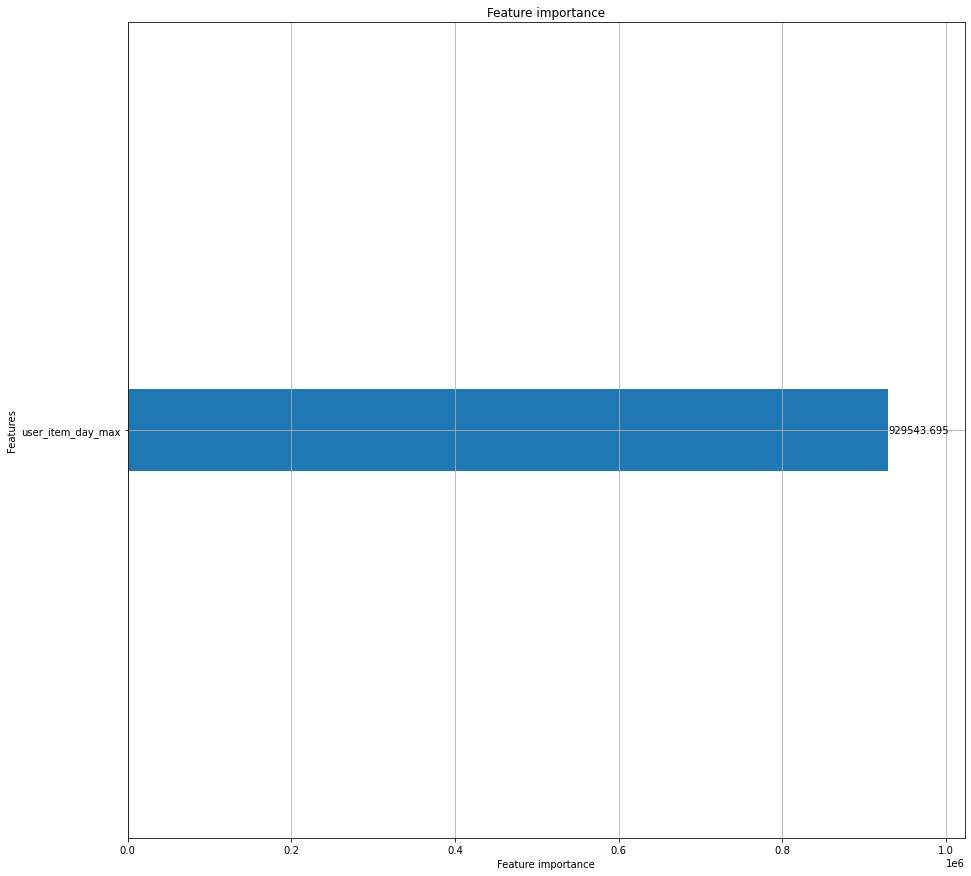

In [102]:
lightgbm.plot_importance(lgb, figsize=(15, 15), importance_type='gain')

In [103]:
%%time
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 10)]
reg_lambda = [int(x) for x in np.linspace(start = 0.1, stop = 1, num = 5)]
reg_alpha = [int(x) for x in np.linspace(start = 0.1, stop = 1, num = 5)]

param_dist = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'reg_lambda': reg_lambda,
              'reg_alpha': reg_alpha
               }

rs = RandomizedSearchCV(lgb, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Unknown parameter: max_features
CPU times: user 1min 40s, sys: 1.85 s, total: 1min 42s
Wall time: 2h 3min 54s


{'reg_lambda': 0,
 'reg_alpha': 1,
 'n_estimators': 560,
 'max_features': 'sqrt',
 'max_depth': 1}

Создам датафрейм, содержащий результаты работы алгоритма RandomizedSearchCV для того чтобы выяснить то, в каком диапазоне значений стоит продолжать поиск.

In [104]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head()

,param_reg_lambda,param_reg_alpha,param_n_estimators,param_max_features,param_max_depth,mean_test_score,rank_test_score
0,0,1,560,sqrt,1,0.999853,1
1,0,1,10,log2,15,0.999853,1
2,0,1,120,sqrt,8,0.999853,1
3,0,1,120,log2,7,0.999853,1
4,1,0,890,sqrt,1,0.999853,1


Создам столбчатые графики, на которых, по оси Х, расположены значения гиперпараметров, а по оси Y — средние значения, показываемые моделями.

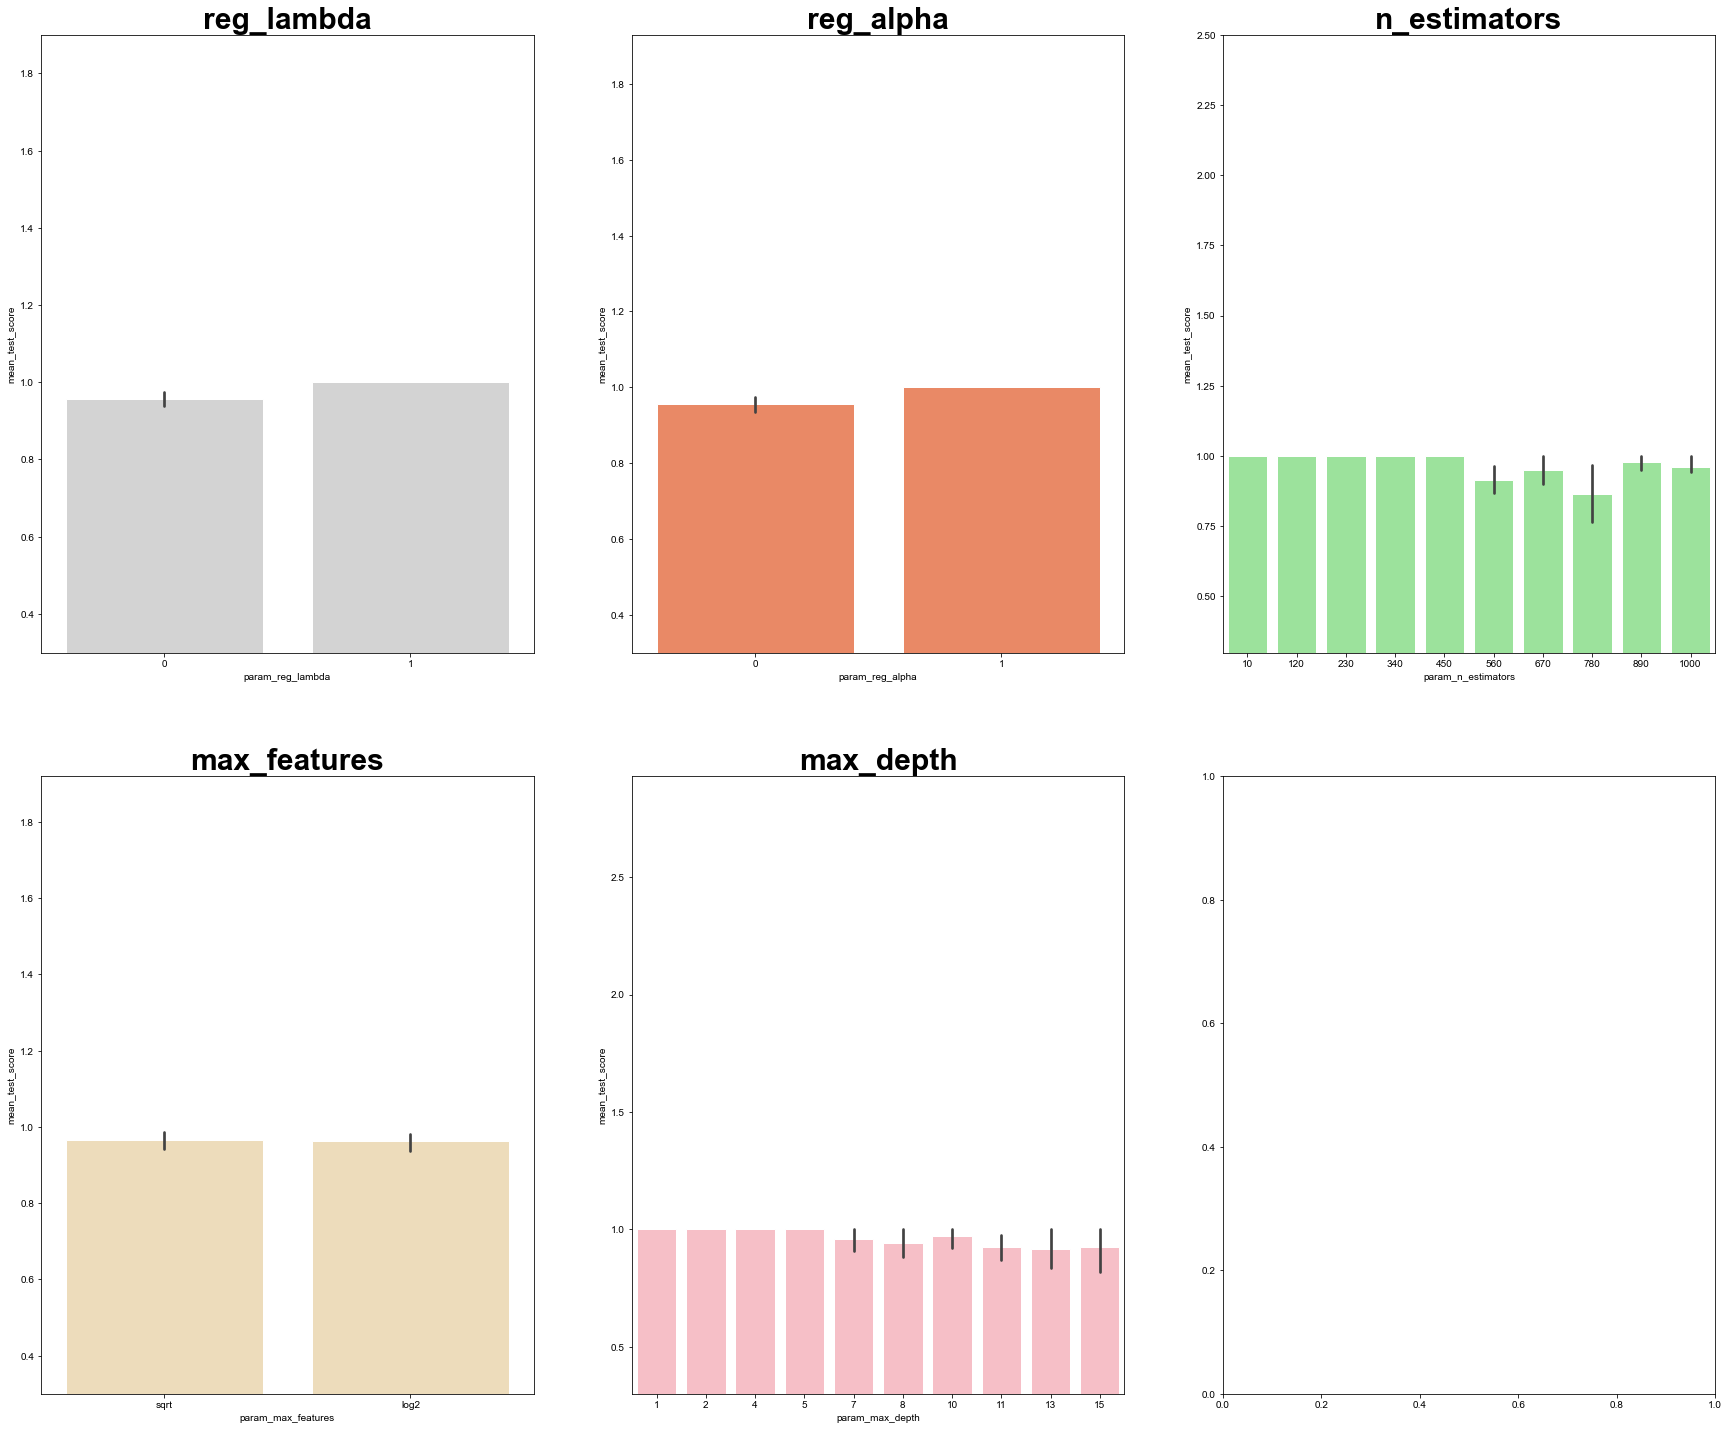

In [105]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_reg_lambda', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.30, 1.900])
axs[0,0].set_title(label = 'reg_lambda', size=30, weight='bold')
sns.barplot(x='param_reg_alpha', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.30, 1.93])
axs[0,1].set_title(label = 'reg_alpha', size=30, weight='bold')
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.30,2.5])
axs[0,2].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.30,1.92])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.30,2.93])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
plt.show()

Анализ показал, что у тюнинга модели очень маленькие возможности. rs.best_params_ уменьшили метрику модели.

P.S. Продвинутые методы подбора гиперпараметров и методов валидации в 2020 году еще не знал.

# 2nd Model validation

In [106]:
users_lvl_2_val = pd.DataFrame(data_val_lvl_2['user_id'].unique())
users_lvl_2_val.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2_val = users_lvl_2_val[users_lvl_2_val['user_id'].isin(train_users)]

users_lvl_2_val['candidates'] = users_lvl_2_val['user_id'].apply(lambda x: imputer)

In [107]:
users_lvl_2_val['user_id'].isin(train_users).sum()

1945

In [108]:
s = users_lvl_2_val.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

In [109]:
users_lvl_2_val = users_lvl_2_val.drop('candidates', axis=1).join(s)

users_lvl_2_val.head(4)

,user_id,item_id
0,338,1082185
0,338,6534178
0,338,1029743
0,338,995242


In [110]:
pred_2 =users_lvl_2_val.merge(item_features, on = 'item_id', how = 'left')

In [111]:
pred_2 =pred_2.merge(user_features, on = 'user_id', how = 'left')

In [112]:
pred_2.head(2)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,income_desc,household_size_desc,kid_category_desc,...,homeowner_desc_Probable Owner,homeowner_desc_Probable Renter,homeowner_desc_Renter,homeowner_desc_Unknown,hh_comp_desc_1 Adult Kids,hh_comp_desc_2 Adults Kids,hh_comp_desc_2 Adults No Kids,hh_comp_desc_Single Female,hh_comp_desc_Single Male,hh_comp_desc_Unknown
0,338,1082185,2.0,PRODUCE,National,TROPICAL FRUIT,BANANAS,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,338,6534178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Добавление фичей в pred_2

In [113]:
pred_2 = pred_2.merge(user_item_day, on=['user_id', 'item_id'], how='left')

In [114]:
#уменьшила метрику
#pred_2 = pred_2.loc[~pred_2.department.isna()]

In [115]:
pred_2.head(2)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,income_desc,household_size_desc,kid_category_desc,...,homeowner_desc_Probable Renter,homeowner_desc_Renter,homeowner_desc_Unknown,hh_comp_desc_1 Adult Kids,hh_comp_desc_2 Adults Kids,hh_comp_desc_2 Adults No Kids,hh_comp_desc_Single Female,hh_comp_desc_Single Male,hh_comp_desc_Unknown,user_item_day_max
0,338,1082185,2.0,PRODUCE,National,TROPICAL FRUIT,BANANAS,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,561.0
1,338,6534178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
X_val = pred_2

In [117]:
cat_feats

['department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'income_desc',
 'household_size_desc',
 'kid_category_desc']

In [118]:
X_val[['user_id', 'item_id']] = X_val[['user_id', 'item_id']].astype('int')

# Предсказания

In [119]:
val_preds = lgb.predict(X_val)

In [120]:
val_preds = lgb.predict_proba(X_val)[:, 1]

In [121]:
pred_2['proba'] = val_preds

In [122]:
recomendations = pred_2[['user_id', 'item_id', 'proba']]

In [123]:
lgbm_recs = pd.DataFrame(recomendations.sort_values(['user_id', 'proba'],\
        ascending = False).groupby('user_id').apply(lambda x:\
                            x['item_id'].iloc[:5].values)).rename(columns = {0: 'lgbm'})

In [124]:
pd.DataFrame(data_val_lvl_2.groupby('user_id')['item_id'].unique()).head()

,item_id
user_id,
1,"[821867, 834484, 856942, 865456, 889248, 90795..."
3,"[835476, 851057, 872021, 878302, 879948, 90963..."
6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
7,"[840386, 889774, 898068, 909714, 929067, 95347..."
8,"[835098, 872137, 910439, 924610, 992977, 10412..."


In [125]:
lgbm_recs = lgbm_recs.merge(pd.DataFrame(
    data_val_lvl_2.groupby('user_id')['item_id'].unique()).rename(columns = \
                        {'item_id': 'actual'}).reset_index(), how = 'left', on = 'user_id')

In [126]:
lgbm_recs.apply(lambda x: precision_at_k(x['lgbm'], x['actual']), axis = 1).mean()*100

33.49100257069409

In [127]:
lgbm_recs.apply(lambda x: ap_k(x['lgbm'], x['actual']), axis = 1).mean()*100

27.09151670951158

# Pairwise (уменьшила метрику)

In [128]:
#from lightgbm import LGBMRanker

In [129]:
#groups = X_train.groupby('user_id').count().iloc[:, 0].values

In [130]:
#assert sum(groups) == X_train.shape[0]

In [131]:
#lgb = LGBMRanker(objective='lambdarank', max_depth=7, categorical_column=cat_feats, reg_lambda=0.8)
#lgb.fit(X_train, y_train, group = groups)

#train_preds = lgb.predict(X_train)

In [132]:
#X_val.drop(columns=['proba'], inplace=True)

In [133]:
#val_preds = lgb.predict(X_val)

In [134]:
#pred_2['proba'] = val_preds

In [135]:
#recomendations = pred_2[['user_id', 'item_id', 'proba']]

In [136]:
#recomendations.head(2)

In [137]:
#lgbm_recs = pd.DataFrame(recomendations.sort_values(['user_id', 'proba'],\
#        ascending = False).groupby('user_id').apply(lambda x:\
#                            x['item_id'].iloc[:5].values)).rename(columns = {0: 'lgbm'})

In [138]:
#lgbm_recs = lgbm_recs.merge(pd.DataFrame(
#    data_val_lvl_2.groupby('user_id')['item_id'].unique()).rename(columns = \
#                        {'item_id': 'actual'}).reset_index(), how = 'left', on = 'user_id')#

In [139]:
#lgbm_recs.head(2)

In [140]:
#lgbm_recs.apply(lambda x: precision_at_k(x['lgbm'], x['actual']), axis = 1).mean()*100

In [141]:
#lgbm_recs.apply(lambda x: ap_k(x['lgbm'], x['actual']), axis = 1).mean()*100

# Генерация предсказания

In [142]:
test_df = pd.read_csv('data/test_users.csv')
test_df.head(2)

,user_id
0,1
1,2


In [143]:
test_df.shape

(1708, 1)

In [144]:
test_df['candidates'] = test_df['user_id'].apply(lambda x: imputer)

Чтобы не запутаться, код будет аналогичным тому, что на обучении

In [145]:
users_lvl_2_val = test_df

In [146]:
users_lvl_2_val.head(2)

,user_id,candidates
0,1,"[1082185, 6534178, 1029743, 995242, 1106523, 9..."
1,2,"[1082185, 6534178, 1029743, 995242, 1106523, 9..."


In [147]:
s = users_lvl_2_val.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

In [148]:
users_lvl_2_val = users_lvl_2_val.drop('candidates', axis=1).join(s)

users_lvl_2_val.head(2)

,user_id,item_id
0,1,1082185
0,1,6534178


In [149]:
pred_2 =users_lvl_2_val.merge(item_features, on = 'item_id', how = 'left')
pred_2 =pred_2.merge(user_features, on = 'user_id', how = 'left')

In [150]:
pred_2.head(2)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,income_desc,household_size_desc,kid_category_desc,...,homeowner_desc_Probable Owner,homeowner_desc_Probable Renter,homeowner_desc_Renter,homeowner_desc_Unknown,hh_comp_desc_1 Adult Kids,hh_comp_desc_2 Adults Kids,hh_comp_desc_2 Adults No Kids,hh_comp_desc_Single Female,hh_comp_desc_Single Male,hh_comp_desc_Unknown
0,1,1082185,2.0,PRODUCE,National,TROPICAL FRUIT,BANANAS,35-49K,2,None/Unknown,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,6534178,NaN,NaN,NaN,NaN,NaN,35-49K,2,None/Unknown,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Добавление фичей в pred_2

In [151]:
pred_2 = pred_2.merge(user_item_day, on=['user_id', 'item_id'], how='left')

In [152]:
pred_2 = pred_2.loc[~pred_2.department.isna()]

In [153]:
X_val = pred_2

In [154]:
val_preds = lgb.predict(X_val)

In [155]:
pred_2['proba'] = val_preds

In [156]:
recomendations = pred_2[['user_id', 'item_id', 'proba']]

In [157]:
recomendations.head(2)

,user_id,item_id,proba
0,1,1082185,1.0
2,1,1029743,0.0


In [158]:
lgbm_recs = pd.DataFrame(recomendations.sort_values(['user_id', 'proba'],\
        ascending = False).groupby('user_id').apply(lambda x:\
                            x['item_id'].iloc[:5].values)).rename(columns = {0: 'lgbm'})

In [159]:
lgbm_recs = lgbm_recs.merge(pd.DataFrame(
    data.groupby('user_id')['item_id'].unique()).rename(columns = \
                        {'item_id': 'actual'}).reset_index(), how = 'left', on = 'user_id')

In [160]:
lgbm_recs.head(2)

,user_id,lgbm,actual
0,1,"[1082185, 995242, 840361, 901062, 820165]","[825123, 831447, 840361, 845307, 852014, 85498..."
1,2,"[1082185, 1106523, 1133018, 916122, 866211]","[854852, 930118, 1077555, 1098066, 5567388, 55..."


In [161]:
lgbm_recs.apply(lambda x: precision_at_k(x['lgbm'], x['actual']), axis = 1).mean()*100

86.44028103044474

In [162]:
lgbm_recs.apply(lambda x: ap_k(x['lgbm'], x['actual']), axis = 1).mean()*100

85.21350507416065

In [163]:
lgbm_recs.shape

(1708, 3)

In [164]:
lgbm_recs.drop(columns=['actual'], inplace=True)

На всякий случай:

In [165]:
test_df = pd.read_csv('data/test_users.csv')
test_df.shape

(1708, 1)

In [166]:
test_df.head(2)

,user_id
0,1
1,2


In [167]:
test_df = test_df.merge(lgbm_recs, how='left', on='user_id')

In [168]:
test_df.head()

,user_id,lgbm
0,1,"[1082185, 995242, 840361, 901062, 820165]"
1,2,"[1082185, 1106523, 1133018, 916122, 866211]"
2,3,"[1082185, 1029743, 995242, 1106523, 981760]"
3,6,"[1082185, 995242, 878996, 994928, 1096036]"
4,7,"[1082185, 1106523, 1133018, 995785, 1126899]"


[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_fe

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_fe

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_fe

/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/jb/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/home/jb/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_